# Made By: Mert Göksel

In [ ]:
library(openxlsx)
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(lmtest))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(leaps))
suppressPackageStartupMessages(library(stats))
suppressPackageStartupMessages(library(olsrr))
options(scipen=999999)

# Question 1

In [ ]:
titanic <- openxlsx::read.xlsx("./titanic.xlsx")
head(titanic)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,3,male,22,1,0,7.2500,S,0
2,1,female,38,1,0,71.2833,C,1
3,3,female,26,0,0,7.9250,S,1
4,1,female,35,1,0,53.1000,S,1
5,3,male,35,0,0,8.0500,S,0
6,3,male,NA,0,0,8.4583,Q,0


In [ ]:
titanic <- drop_na(titanic)

In [ ]:
titanic_train_indexes <- sample(1:nrow(titanic), 
                        floor(nrow(titanic)*8/10)) #80% is train
titanic_train <- titanic[titanic_train_indexes,]
titanic_test <- titanic[-titanic_train_indexes,]

## Part A

In [ ]:
model.titanic <- glm(Survived~., data=titanic_train, family="binomial")

In [ ]:
summary(model.titanic)


Call:
glm(formula = Survived ~ ., family = "binomial", data = titanic_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7721  -0.6504  -0.3846   0.6086   2.4730  

Coefficients:
             Estimate Std. Error z value             Pr(>|z|)    
(Intercept)  5.673589   0.719559   7.885  0.00000000000000315 ***
Pclass      -1.156675   0.185452  -6.237  0.00000000044585241 ***
Sexmale     -2.641776   0.254601 -10.376 < 0.0000000000000002 ***
Age         -0.045404   0.009402  -4.829  0.00000137083254779 ***
SibSp       -0.406540   0.153465  -2.649              0.00807 ** 
Parch       -0.056003   0.133190  -0.420              0.67414    
Fare         0.002710   0.002991   0.906              0.36487    
EmbarkedQ   -1.275800   0.755194  -1.689              0.09115 .  
EmbarkedS   -0.497597   0.293659  -1.694              0.09018 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Nul

From this model, our response function is;

In [ ]:
cat("logodds =\n")
cat(paste(row.names(summary(model.titanic)$coefficients),
          summary(model.titanic)$coefficients[,1], sep="*"),sep="+\n")

logodds =
(Intercept)*5.67358895483166+
Pclass*-1.15667548042592+
Sexmale*-2.64177601006429+
Age*-0.0454041069105764+
SibSp*-0.406539865581682+
Parch*-0.0560025984992716+
Fare*0.00271048568385791+
EmbarkedQ*-1.2757998748757+
EmbarkedS*-0.497597022492682


## Part B

We have our parameters above, these are for the logodds. 
Meaning if above function is $BX$, then;

$$
\begin{aligned}
&logodds = BX \\
&\Rightarrow \; ln(\frac{\pi(x)}{1-\pi(x)}) = BX \\
&\Rightarrow \; \pi(x) = \frac{e^{BX}}{1+e^{BX}} \\
&\Rightarrow \; \pi(x) = \frac{1}{1+e^{-BX}}
\end{aligned}
$$

From this formula we can interpret these coefficient as following:
- When BX = logodds, unit of increase in any variable will increase/decrease the logodds by the respective coefficient. Meaning, the odds will be affected as much as $e^{B_k}$
- On the other side, if we are looking at probability formula the change in the probability will be;
$$
\begin{aligned}
\\
When\;x_i &\Rightarrow x_i+1 \\
B_i * x_i &\Rightarrow B_i * x_i+B_i \\
\pi(x) &\Rightarrow \frac{1}{1+e^{-(B_ix_i + B_i)}}
\end{aligned}
$$

These apply for each parameter.

## Part C

In [ ]:
given <- data.frame(Pclass=3, Sex="female", Age=35, SibSp=0, Parch=0, Fare=75, Embarked="C")
predict(model.titanic, given, type="response")

1 
0.693749

## Part D

We will apply wald test to all parameters with size $\alpha = 0.01$

$$
Reject \; H_0 \Rightarrow |z^*| > z_{\frac{1- \alpha}{2}}
$$

In [ ]:
qnorm(0.01, lower.tail = 0)

[1] 2.326348

In [ ]:
qnorm(0.01/2, lower.tail = 0)

[1] 2.575829

In [ ]:
data.frame(z=summary(model.titanic)$coefficients[,3]) %>% 
    mutate(z_star = abs(z), reject = ifelse(z_star > qnorm(0.01/2, lower.tail = 0), 1, 0))

,z,z_star,reject
,<dbl>,<dbl>,<dbl>
(Intercept),7.8848195,7.8848195,1
Pclass,-6.2370665,6.2370665,1
Sexmale,-10.3761564,10.3761564,1
Age,-4.8291992,4.8291992,1
SibSp,-2.6490705,2.6490705,1
Parch,-0.4204700,0.4204700,0
Fare,0.9061304,0.9061304,0
EmbarkedQ,-1.6893662,1.6893662,0
EmbarkedS,-1.6944745,1.6944745,0


Wald test tells us that __Parch, Fare and Embarked__ are insignificant variables and thus needs to be dropped

## Part E

To test the overall significance of the model we have to use __Likelihood__ test

In [ ]:
summary(model.titanic)


Call:
glm(formula = Survived ~ ., family = "binomial", data = titanic_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7721  -0.6504  -0.3846   0.6086   2.4730  

Coefficients:
             Estimate Std. Error z value             Pr(>|z|)    
(Intercept)  5.673589   0.719559   7.885  0.00000000000000315 ***
Pclass      -1.156675   0.185452  -6.237  0.00000000044585241 ***
Sexmale     -2.641776   0.254601 -10.376 < 0.0000000000000002 ***
Age         -0.045404   0.009402  -4.829  0.00000137083254779 ***
SibSp       -0.406540   0.153465  -2.649              0.00807 ** 
Parch       -0.056003   0.133190  -0.420              0.67414    
Fare         0.002710   0.002991   0.906              0.36487    
EmbarkedQ   -1.275800   0.755194  -1.689              0.09115 .  
EmbarkedS   -0.497597   0.293659  -1.694              0.09018 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Nul

We know that likelihood of the model will be used as following to test the significance;

$$
LR \sim \chi^{2}_{0.95, 8} \\
LR=2ln(\frac{L(FM)}{L(RM)})
$$


In [ ]:
model.titanic.reduced <- glm(Survived~1, data=titanic, family = 'binomial')

In [ ]:
summary(model.titanic.reduced)


Call:
glm(formula = Survived ~ 1, family = "binomial", data = titanic)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.018  -1.018  -1.018   1.345   1.345  

Coefficients:
            Estimate Std. Error z value    Pr(>|z|)    
(Intercept) -0.38677    0.07636  -5.065 0.000000408 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 960.9  on 711  degrees of freedom
Residual deviance: 960.9  on 711  degrees of freedom
AIC: 962.9

Number of Fisher Scoring iterations: 4


In [ ]:
lr <- 2*(logLik(model.titanic)[1] - logLik(model.titanic.reduced)[1])

In [ ]:
lr

[1] 458.9503

In [ ]:
pchisq(454.837105802761, df = 8, lower.tail = 0)

[1] 0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000003399737

well, since this test score is basically 0 and thus $<0.05$ we will reject $H_0$ and say that this model is significant.

## Part F

In order to get confidence intervals for the parameters we will use this formula

$$
\hat{\beta}_k \pm z_{\frac{1-\alpha}{2}}.se(\hat{\beta}_k)
$$

In [22]:
conf <- as.data.frame(summary(model.titanic)$coefficients) %>% mutate(std.error = `Std. Error`, z.val = `z value`, `z value` = NULL, `Std. Error` = NULL) %>%
    select(Estimate, std.error, z.val) %>% 
    mutate(conf.int_lower = Estimate-qnorm(0.05/2, lower.tail = 0)*std.error,
           conf.int_higher = Estimate+qnorm(0.05/2, lower.tail = 0)*std.error)

In [23]:
conf

,Estimate,std.error,z.val,conf.int_lower,conf.int_higher
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.673588955,0.719558508,7.8848195,4.263280194,7.083897715
Pclass,-1.156675480,0.185451843,-6.2370665,-1.520154413,-0.793196548
Sexmale,-2.641776010,0.254600636,-10.3761564,-3.140784087,-2.142767933
Age,-0.045404107,0.009401995,-4.8291992,-0.063831679,-0.026976535
SibSp,-0.406539866,0.153465099,-2.6490705,-0.707325932,-0.105753799
Parch,-0.056002598,0.133190472,-0.4204700,-0.317051126,0.205045929
Fare,0.002710486,0.002991276,0.9061304,-0.003152307,0.008573278
EmbarkedQ,-1.275799875,0.755194392,-1.6893662,-2.755953685,0.204353935
EmbarkedS,-0.497597022,0.293658600,-1.6944745,-1.073157302,0.077963257


The confidence intervals with size $\alpha$ gives us the possible values of the said variable. Generally, if this confidence interval includes 0 as a possible value then that variable is insignificant.

## Part G

$$
\begin{aligned}
confidence\; interval \Rightarrow \; &lower < \;\beta_i < higher  \\\\
\Rightarrow \; &e^{lower} < e^{\beta_i} < e^{higher} \\\\
\Rightarrow \; &\frac{e^{lower}}{e^{\beta_i}+1} < \;\frac{e^{\beta_i}}{{e^{\beta_i}+1}} < \frac{e^{higher}}{{e^{\beta_i}+1}}
\end{aligned}
$$

In [26]:
conf %>% mutate(conf.int_lower_exponential = exp(conf.int_lower)/(exp(Estimate)+1),
                conf.int_higher_exponential = exp(conf.int_higher)/(exp(Estimate)+1))

,Estimate,std.error,z.val,conf.int_lower,conf.int_higher,conf.int_lower_exponential,conf.int_higher_exponential
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.673588955,0.719558508,7.8848195,4.263280194,7.083897715,0.24323229,4.0831924
Pclass,-1.156675480,0.185451843,-6.2370665,-1.520154413,-0.793196548,0.16635459,0.3441506
Sexmale,-2.641776010,0.254600636,-10.3761564,-3.140784087,-2.142767933,0.04037292,0.1095275
Age,-0.045404107,0.009401995,-4.8291992,-0.063831679,-0.026976535,0.47972873,0.4977391
SibSp,-0.406539866,0.153465099,-2.6490705,-0.707325932,-0.105753799,0.29590353,0.5400197
Parch,-0.056002598,0.133190472,-0.4204700,-0.317051126,0.205045929,0.37434068,0.6309732
Fare,0.002710486,0.002991276,0.9061304,-0.003152307,0.008573278,0.49775084,0.5036216
EmbarkedQ,-1.275799875,0.755194392,-1.6893662,-2.755953685,0.204353935,0.04967793,0.9589783
EmbarkedS,-0.497597022,0.293658600,-1.6944745,-1.073157302,0.077963257,0.21264266,0.6723195


After this transformation now this confidence interval became the probabilities confidence interval.

## Part H

In [ ]:
library(ResourceSelection)

In [ ]:
hoslem.test(titanic_train$Survived, model.titanic$fitted.values)

Since our value is more extreme we will reject $H_0$ and say that model is not a good fit.

## Part I

In [ ]:
predictions <- ifelse(predict(model.titanic, titanic_test %>% select(-Survived), type='response') > 0.5, 1, 0)

In [ ]:
model.df <- data.frame(real=titanic_test$Survived, prediction=predictions)

In [ ]:
t(table(model.df))

In [ ]:
sensitivity <- 44/(44+14)
specificity <- 66/(66+19)
prevalence <- (66+44)/(66+14+19+44)
noinfrate <- (66+19)/(66+14+19+44)

In [ ]:
ppv <- sensitivity*prevalence/((sensitivity+prevalence)+((1-specificity)*(1-prevalence)))
npv <- sensitivity*(1-prevalence)/(((1-sensitivity)+prevalence)+((specificity)*(1-prevalence)))

In [ ]:
detection.rate <- 44/(66+14+19+44)
detection.prevalence <- (44+14)/(66+14+19+44)
balanced.acc <- (sensitivity+specificity)/2
precision = 44/(14+44)
recall = 44/(19+44)

In [ ]:
sensitivity
specificity
noinfrate
prevalence
ppv
npv
detection.rate
detection.prevalence
balanced.acc
precision
recall

In [ ]:
confusionMatrix(factor(model.df$prediction), factor(model.df$real), positive = "0")

same.

## Part J

In [ ]:
library(pROC)

In [ ]:
g <- roc(Survived ~ model.titanic$fitted.values, data=titanic_train)
plot(g)
points(.8,.8)
abline(0.8,0)
abline(v=0.8)
abline(0,1)

0.8 for both sensitivity and specificity seems like the most efficient point. This plot visualizes the trade off between sensitivity and specificity, best place is the most left upper corner.

# Q2

## Part A

### Forward Selection

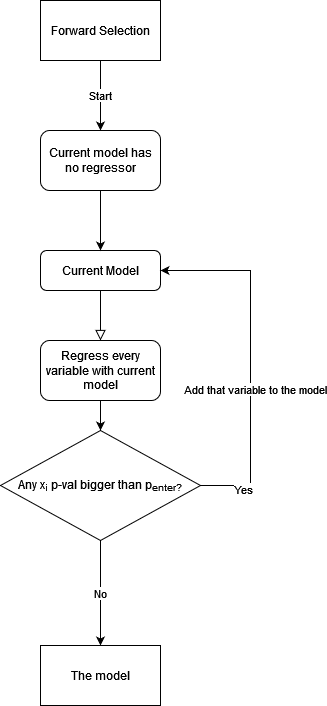{width=200px}

### Backwards elimination

<img src="pictures/backward.png" width="200" height="500" />

### Stepwise regression

<img src="pictures/stepwise.png" width="300" height="500" />

## Part B

Model validation may not be mentioned alot in papers but its a must have component of model building as it is the process of making sure that model works and can be used in real life. 

## Part C

- Gender
- Age
- n.projects
- Graduation.CGPA
- haslover
- personality
- enthusiasm
- living.place
- living.conditions.score
- monthly.earnings
- has.necessary.equipment
- disability.severity

## Part D

Thats because we want to be adding variables less often than we remove them. If the p value for the entry is higher than p value for removal then that means we will needlessly increase the size of the model with not so good variables.

# Q3

In [ ]:
train <- read.xlsx("./job_model_building_data.xlsx")
test <- read.xlsx("./job_validation_data.xlsx")


In [ ]:
head(train)

In [ ]:
head(test)

## Part A

In [ ]:
pairs(train)

In [ ]:
library(corrplot)

In [ ]:
corrplot(cor(train %>% select(-y)))

x3 & x4 seems to be highly correlated, there may be multicolinearity problem. Also in the plots, y\~x3 and y\~x4 looks near identical.

In [ ]:
vif(lm(y~., data=train))

These vif values are not that high. But if we wanted to be more conservative we could drop either x3 or x4.

## Part B

In [ ]:
model.new <- lm(y~., data=train)

In [ ]:
summary(model.new)

To me it seems like x2 should be dropped. That is because 0 is within the confidence interval. 

## Part C

In [ ]:
number.of.predictors <- 4
predictor.names <- colnames(train)[1:number.of.predictors]
ind <- expand.grid(c(1,0), c(1,0), c(1,0), c(1,0))
c <- c()
for(i in 1:nrow(ind)){
c[i] <- paste(predictor.names[as.logical(ind[i,])], collapse="+")
}
c[16] <- 1
c <- c[order(nchar(c))]
c <- paste("y ~", c)
all <- data.frame(formula=rep(NA, 16), rsq.p= rep(NA, 16))
for(i in 1:length(c)){
    all$formula[i] <- c[i]
    all$rsq.p[i] <- summary(lm(as.formula(c[i]), data=train))$adj.r.squared
}

In [ ]:
all$p <- c(1,2,2,2,2,3,3,3,3,3,3,4,4,4,4,5)
all

In [ ]:
max.rsq <- group_by(all, p) %>% summarize(max.rsq=max(rsq.p))
ggplot(all, aes(p, rsq.p)) + geom_point() + ylab("R2.adj(p)") + geom_line(data= max.rsq, aes(p,max.rsq))

When the formula is *y = x1 + x3 + x4* the $R^2_{adj}$ has the highest value.

## Part D

In [ ]:
model <- lm(y~., data=train)
ols_step_both_p(model, pent = 0.05, prem = 0.1)$model

## Part E

They are the same..

## Part F

In [ ]:
model.new <- lm(y~.-x2, train)
PRESS <- function(model) {
    i <- residuals(model)/(1 - lm.influence(model)$hat)
    sum(i^2)
}
PRESS(model.new)

$$
SSE: \; \sum (\hat{y} - \bar{y})^2 \\
MSE: \; \frac{SSE}{n-p} \\
$$

In [ ]:
sse <- sum((model.new$fitted.values - train$y)**2)
sse

In [ ]:
mse <- sse/(nrow(train)-1)

## Part G 

In [ ]:
par(mfrow=c(1,2))
corrplot(cor(train %>% select(-y)), type="upper", title = "Train")
corrplot(cor(test %>% select(-y)), type="upper", title = "Test")

corplots are near identical with the sole difference being correlation of x2~x4

## Part H

In [ ]:
summary(lm(y~.-x2, test))

In [ ]:
summary(model.new)

These two models look very alike but the importance of x4 seems to be much higher in the test model. This might mean that model is not correctly specified.

In [ ]:
data.frame(train=c(4.284, 0.94), test=c(4.072, 0.96), row.names = c("MSE", "Rsquared"))

As we can see the values are near identical. This means the model has high chance to work with new data. It is useful.

## Part I

In [ ]:
mspe <- sum((predict(model.new, test %>% select(-y), type="response")-test$y)**2)/(nrow(test)-1)

In [ ]:
mspe
mse

mean squared errors are close also.

## Part J

In [ ]:
df <- rbind(train, test)
model.full <- lm(y~.-x2, df)

In [ ]:
summary(model.new)$coefficients[,'Std. Error']

In [ ]:
data.frame(train = summary(model.new)$coefficients[,'Std. Error'], full = summary(model.full)$coefficients[,'Std. Error'])

All standard deviations are lower, although not that much.